# Rectangle Packing (2D Bin Packing)

矩形铝板是53*32cm的规格，现在要剪成若干个长7cm，宽5cm的小矩形铝板，请问怎么剪可以剪最多?

## Set Covering Model

In [ ]:
from itertools import product
from typing import Tuple, List, Dict
from ortools.sat.python import cp_model

class SetCoverSolver:
    def __init__(self, grid: Tuple[int, int], shapes: List[Tuple[int, int]], upper_bound: int):
        self.grid = grid  # Size of board (width, height)
        self.shapes = shapes  # Rectangle size [(width1,height1), (width2,height2), ...]
        self.upper_bound = upper_bound  # Maximum number of rectangles
        self.model = cp_model.CpModel()  # CP-SAT
        self.solver = cp_model.CpSolver()  # Solver
        self.x = {}  # Decision Variables
        self.y = {}  # Position variables
        self.cell_neighbors = {}  # Coverage Relationships
        self.cell_shapes = {}  # Possible Placement

    def solve(self):
        self._set_iterables()
        self._set_variables()
        self._set_objective()
        self._set_constraints()
        self._optimize()
        return self._post_process()

    def _set_iterables(self):
        """设置问题所需的集合和映射关系"""
        # 所有板材单元格坐标
        self.cells = [(i, j) for i in range(self.grid[0])
                      for j in range(self.grid[1])]
        
        # 扩展的形状索引 (形状索引, 实例编号)
        self.extended_shapes = [(s, n) for s, _ in enumerate(self.shapes)
                                for n in range(self.upper_bound)]
        
        # 为每个形状生成可能的放置位置
        self.cell_shapes = {
            s: self._generate_limited_cells(shape)
            for s, shape in enumerate(self.shapes)
        }
        
        # 所有可能的放置方案 (形状, 实例号, 位置x, 位置y)
        self.cell_shape_list = [(s, n, i, j) for (s, n) in self.extended_shapes
                                for (i, j) in self.cell_shapes[s]]
        
        # 计算每个单元格被哪些放置方案覆盖
        self.cell_neighbors = {}
        for (i, j) in self.cells:
            neighbors = []
            for s, shape in enumerate(self.shapes):
                for (k, l) in self.cell_shapes[s]:
                    if self._is_valid(i, j, k, l, shape):
                        neighbors.append((s, k, l))
            self.cell_neighbors[(i, j)] = neighbors

    def _set_variables(self):
        """创建决策变量"""
        # x[s, n]: 是否使用形状s的第n个实例
        for (s, n) in self.extended_shapes:
            self.x[(s, n)] = self.model.NewBoolVar(f'x_{s}_{n}')
        
        # y[s, n, i, j]: 形状s的第n个实例是否放置在位置(i,j)
        for (s, n, i, j) in self.cell_shape_list:
            self.y[(s, n, i, j)] = self.model.NewBoolVar(f'y_{s}_{n}_{i}_{j}')

    def _set_objective(self):
        """设置目标函数：最大化放置的矩形数量"""
        self.model.Maximize(sum(self.x[(s, n)] for (s, n) in self.extended_shapes))

    def _set_constraints(self):
        """添加问题约束"""
        # 约束1: 如果使用了某个形状实例，则必须为其分配一个位置
        for (s, n) in self.extended_shapes:
            self.model.Add(
                self.x[(s, n)] == sum(
                    self.y[(s, n, i, j)] for (i, j) in self.cell_shapes[s]
                )
            )
        
        # 约束2: 每个单元格最多被一个矩形覆盖
        for (i, j), neighbors in self.cell_neighbors.items():
            # 计算覆盖此单元格的所有可能放置方案
            cover_vars = []
            for (s, k, l) in neighbors:
                # 对于每个可能覆盖此单元格的放置方案(s, k, l)
                # 我们需要考虑所有实例n
                for n in range(self.upper_bound):
                    if (s, n, k, l) in self.y:
                        cover_vars.append(self.y[(s, n, k, l)])
            
            # 添加约束：最多只有一个矩形覆盖此单元格
            if cover_vars:
                self.model.Add(sum(cover_vars) <= 1)

    def _optimize(self):
        """求解优化问题"""
        # 设置求解器参数
        self.solver.parameters.max_time_in_seconds = 3600  # 1小时时间限制
        self.solver.parameters.num_search_workers = 8  # 使用多线程
        
        # 求解问题
        status = self.solver.Solve(self.model)
        
        # 检查求解状态
        if status not in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
            raise RuntimeError("No solution found!")

    def _post_process(self):
        """提取并返回解决方案"""
        blocks = []
        for (s, n, i, j) in self.cell_shape_list:
            if self.solver.Value(self.y[(s, n, i, j)]) == 1:
                w, h = self.shapes[s]
                blocks.append({
                    'shape': (w, h),
                    'position': (i, j),
                    'corners': [
                        [i, j], 
                        [i + w, j],
                        [i + w, j + h], 
                        [i, j + h],
                        [i, j]  # 闭合多边形
                    ]
                })
        return blocks

    def _generate_limited_cells(self, shape: Tuple[int, int]):
        """生成可能的放置位置"""
        w, h = shape
        x_points = []
        # 生成x方向可能的位置
        for i in range(self.grid[0] // w + 1):
            for j in range(self.grid[0] // h + 1):
                x_pos = i * w + j * h
                if x_pos <= self.grid[0] - w:
                    x_points.append(x_pos)
        
        y_points = []
        # 生成y方向可能的位置
        for i in range(self.grid[1] // h + 1):
            for j in range(self.grid[1] // w + 1):
                y_pos = i * h + j * w
                if y_pos <= self.grid[1] - h:
                    y_points.append(y_pos)
        
        # 去重并排序
        x_points = sorted(set(x_points))
        y_points = sorted(set(y_points))
        
        # 生成所有可能的放置位置
        return [(x, y) for x in x_points for y in y_points]

    def _is_valid(self, i, j, k, l, shape):
        """If cell (i, j) can be covered by shape in (k, l) """
        w, h = shape
        return (k <= i < k + w) and (l <= j < l + h)

# 使用示例
if __name__ == "__main__":
    # 板材尺寸
    grid = (53, 32)
    # 要切割的小矩形尺寸
    shapes = [(7, 5), (5, 7)]
    # 计算理论最大数量
    upper_bound = (grid[0] // shapes[0][0]) * (grid[1] // shapes[0][1])
    
    # 创建求解器并求解
    solver = SetCoverSolver(grid, shapes, upper_bound)
    solution = solver.solve()
    
    # 输出结果
    print(f"共放置了 {len(solution)} 个小矩形")
    for block in solution:
        print(f"矩形 {block['shape']} 放置在位置 {block['position']}")

共放置了 47 个小矩形
矩形 (7, 5) 放置在位置 (14, 22)
矩形 (7, 5) 放置在位置 (29, 15)
矩形 (7, 5) 放置在位置 (0, 12)
矩形 (7, 5) 放置在位置 (7, 17)
矩形 (7, 5) 放置在位置 (20, 17)
矩形 (7, 5) 放置在位置 (29, 20)
矩形 (7, 5) 放置在位置 (41, 15)
矩形 (7, 5) 放置在位置 (7, 27)
矩形 (7, 5) 放置在位置 (0, 27)
矩形 (7, 5) 放置在位置 (14, 27)
矩形 (7, 5) 放置在位置 (29, 10)
矩形 (7, 5) 放置在位置 (46, 0)
矩形 (7, 5) 放置在位置 (7, 7)
矩形 (7, 5) 放置在位置 (25, 5)
矩形 (7, 5) 放置在位置 (25, 0)
矩形 (7, 5) 放置在位置 (39, 0)
矩形 (7, 5) 放置在位置 (32, 5)
矩形 (7, 5) 放置在位置 (0, 22)
矩形 (7, 5) 放置在位置 (0, 7)
矩形 (7, 5) 放置在位置 (46, 5)
矩形 (7, 5) 放置在位置 (0, 17)
矩形 (7, 5) 放置在位置 (21, 27)
矩形 (7, 5) 放置在位置 (41, 20)
矩形 (7, 5) 放置在位置 (7, 12)
矩形 (7, 5) 放置在位置 (39, 5)
矩形 (7, 5) 放置在位置 (41, 10)
矩形 (7, 5) 放置在位置 (21, 22)
矩形 (7, 5) 放置在位置 (7, 22)
矩形 (7, 5) 放置在位置 (32, 0)
矩形 (5, 7) 放置在位置 (28, 25)
矩形 (5, 7) 放置在位置 (24, 10)
矩形 (5, 7) 放置在位置 (48, 10)
矩形 (5, 7) 放置在位置 (5, 0)
矩形 (5, 7) 放置在位置 (33, 25)
矩形 (5, 7) 放置在位置 (14, 7)
矩形 (5, 7) 放置在位置 (10, 0)
矩形 (5, 7) 放置在位置 (36, 17)
矩形 (5, 7) 放置在位置 (43, 25)
矩形 (5, 7) 放置在位置 (15, 0)
矩形 (5, 7) 放置在位置 (38, 25)
矩形 (5, 7) 放置

## Guillotine Model

In [31]:

from typing import Tuple, List, Dict, Set
from dataclasses import dataclass
from queue import SimpleQueue
from ortools.sat.python import cp_model

@dataclass(eq=True, frozen=True, unsafe_hash=True)
class Rect:
    width: int
    height: int

class GuillotineSolver:
    """
    基于 Furini et al. (2016) 的 Guillotine 切割模型
    使用 OR-Tools CP-SAT 求解器实现
    
    References:
        Fabio Furini, Enrico Malaguti, Dimitri Thomopulos (2016) Modeling Two-Dimensional Guillotine Cutting Problems via Integer
        Programming. INFORMS Journal on Computing 28(4):736-751. https://doi.org/10.1287/ijoc.2016.0710
    """
    def __init__(self, grid: Tuple[int, int], shapes: List[Tuple[int, int]], upper_bound: int):
        self.grid = grid  # 板材尺寸 (宽度, 高度)
        self.shapes = shapes  # 小矩形形状列表 [(宽1,高1), (宽2,高2), ...]
        self.upper_bound = upper_bound  # 每种形状的最大可能数量
        self.orients = {'h', 'v'}  # 切割方向: 'h'水平, 'v'垂直
        
        # 初始化模型
        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()
        
        # 数据结构
        self.cap_j = {}  # 所有板块和物品的索引映射
        self.cap_j_plates = set()  # 板块索引
        self.cap_j_items = set()  # 物品索引
        self.cut_pos_dict = {}  # 每个板块和方向的切割位置
        self.plate_cut_dict = {}  # 切割后生成的板块
        self.inverse_plate_cut_dict = {}  # 反向映射
        self.cut_set = set()  # 所有可能的切割操作
        
        # 变量
        self.y = {}  # 物品数量变量
        self.x = {}  # 切割操作变量

    def solve(self):
        """解决板材切割问题并返回结果"""
        self._plate_variable_enumeration()
        self._set_variables()
        self._set_objective()
        self._set_constraints()
        self._optimize()
        return self._post_process()

    def _plate_variable_enumeration(self):
        """枚举所有可能的板块和切割位置"""
        cut_pos_dict = {}
        shape_j = set()
        cap_j = {}
        inverse_cap_j = {}
        cap_j_set = set()
        un_processed = set()
        
        # 添加原始板材
        grid = Rect(self.grid[0], self.grid[1])
        cap_j[0] = grid
        inverse_cap_j[grid] = 0
        cap_j_set.add(grid)
        un_processed.add(0)

        # 添加所有形状
        for shape in self.shapes:
            rect_shape = Rect(shape[0], shape[1])
            count = len(cap_j)
            cap_j[count] = rect_shape
            inverse_cap_j[rect_shape] = count
            cap_j_set.add(rect_shape)
            shape_j.add(count)

        x_set = set()
        cut_dict = {}
        inverse_cut_dict = {}

        while un_processed:
            plate_idx = un_processed.pop()
            plate = cap_j[plate_idx]
            for o in self.orients:
                positions = self._compute_possible_cut_positions(plate, o)
                cut_pos_dict[plate_idx, o] = positions
                for position in positions:
                    plate1, plate2 = self._cut(plate, o, position)
                    
                    # 添加新板块
                    if plate1 not in cap_j_set:
                        count = len(cap_j)
                        cap_j[count] = plate1
                        inverse_cap_j[plate1] = count
                        cap_j_set.add(plate1)
                        un_processed.add(count)
                    
                    if plate2 not in cap_j_set:
                        count = len(cap_j)
                        cap_j[count] = plate2
                        inverse_cap_j[plate2] = count
                        cap_j_set.add(plate2)
                        un_processed.add(count)
                    
                    # 记录切割操作
                    cut_key = (plate_idx, position, o)
                    x_set.add(cut_key)
                    
                    plate1_idx = inverse_cap_j[plate1]
                    plate2_idx = inverse_cap_j[plate2]
                    cut_dict[cut_key] = [plate1_idx, plate2_idx]
                    
                    inverse_cut_dict.setdefault(
                        (plate1_idx, o), []).append((position, plate_idx))
                    inverse_cut_dict.setdefault(
                        (plate2_idx, o), []).append((position, plate_idx))

        # 保存结果
        self.cap_j = cap_j
        self.cap_j_items = shape_j
        self.cut_set = x_set
        self.plate_cut_dict = cut_dict
        self.inverse_plate_cut_dict = inverse_cut_dict
        self.cut_pos_dict = cut_pos_dict
        self.cap_j_plates = set(cap_j.keys()).difference(shape_j)

    def _set_variables(self):
        """创建决策变量"""
        # y[j]: 物品j的数量
        for j in self.cap_j_items:
            self.y[j] = self.model.NewIntVar(0, self.upper_bound, f'y_{j}')
        
        # x[plate, pos, orient]: 在板块上进行切割的次数
        for cut_key in self.cut_set:
            self.x[cut_key] = self.model.NewIntVar(0, self.upper_bound, f'x_{cut_key}')

    def _set_objective(self):
        """设置目标函数：最大化物品数量"""
        self.model.Maximize(sum(self.y[j] for j in self.cap_j_items))

    def _set_constraints(self):
        """添加问题约束"""
        # 约束1: 物品数量约束
        for j in self.cap_j_items:
            # 计算所有可以产生物品j的切割操作
            incoming_cuts = []
            for o in self.orients:
                if (j, o) in self.inverse_plate_cut_dict:
                    for (pos, plate) in self.inverse_plate_cut_dict[(j, o)]:
                        cut_key = (plate, pos, o)
                        if cut_key in self.x:
                            incoming_cuts.append(self.x[cut_key])
            
            # 计算所有从物品j出发的切割操作
            outgoing_cuts = []
            for o in self.orients:
                if (j, o) in self.cut_pos_dict:
                    for pos in self.cut_pos_dict[(j, o)]:
                        cut_key = (j, pos, o)
                        if cut_key in self.x:
                            outgoing_cuts.append(self.x[cut_key])
            
            # 添加约束: 流入切割 - 流出切割 >= 物品数量
            self.model.Add(sum(incoming_cuts) - sum(outgoing_cuts) - self.y[j] >= 0)
        
        # 约束2: 板块流量平衡
        for j in self.cap_j_plates:
            if j == 0:  # 跳过原始板材
                continue
            
            # 计算所有可以产生板块j的切割操作
            incoming_cuts = []
            for o in self.orients:
                if (j, o) in self.inverse_plate_cut_dict:
                    for (pos, plate) in self.inverse_plate_cut_dict[(j, o)]:
                        cut_key = (plate, pos, o)
                        if cut_key in self.x:
                            incoming_cuts.append(self.x[cut_key])
            
            # 计算所有从板块j出发的切割操作
            outgoing_cuts = []
            for o in self.orients:
                if (j, o) in self.cut_pos_dict:
                    for pos in self.cut_pos_dict[(j, o)]:
                        cut_key = (j, pos, o)
                        if cut_key in self.x:
                            outgoing_cuts.append(self.x[cut_key])
            
            # 添加约束: 流入切割 >= 流出切割
            self.model.Add(sum(incoming_cuts) - sum(outgoing_cuts) >= 0)
        
        # 约束3: 原始板材只能被切割一次
        original_cuts = []
        for o in self.orients:
            if (0, o) in self.cut_pos_dict:
                for pos in self.cut_pos_dict[(0, o)]:
                    cut_key = (0, pos, o)
                    if cut_key in self.x:
                        original_cuts.append(self.x[cut_key])
        
        if original_cuts:
            self.model.Add(sum(original_cuts) <= 1)

    def _optimize(self):
        """求解优化问题"""
        # 设置求解器参数
        self.solver.parameters.max_time_in_seconds = 3600  # 1小时时间限制
        self.solver.parameters.num_search_workers = 8  # 使用多线程
        
        # 求解问题
        status = self.solver.Solve(self.model)
        
        # 检查求解状态
        if status not in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
            raise RuntimeError("No solution found!")

    def _post_process(self):
        """提取并返回解决方案"""
        result_y = {}
        result_x = {}
        
        # 提取物品数量
        for j in self.cap_j_items:
            value = self.solver.Value(self.y[j])
            if value > 0:
                result_y[j] = value
        
        # 提取切割操作
        for cut_key in self.cut_set:
            value = self.solver.Value(self.x[cut_key])
            if value > 0:
                plate_idx, pos, o = cut_key
                result_x[plate_idx] = ((pos, o), value)
        
        # 获取最终切割结果
        return self._get_final_results(result_y, result_x)

    def _compute_possible_cut_positions(self, plate: Rect, o: str) -> List[int]:
        """计算可能的切割位置"""
        positions = set()
        
        if o == 'h':  # 水平切割
            # 计算所有可能的切割高度
            for shape in self.shapes:
                if shape[1] <= plate.height:
                    # 添加所有可能的切割位置
                    for h in range(shape[1], plate.height, shape[1]):
                        positions.add(h)
            
            # 确保切割位置在有效范围内
            positions = [p for p in positions if 0 < p < plate.height]
        
        elif o == 'v':  # 垂直切割
            # 计算所有可能的切割宽度
            for shape in self.shapes:
                if shape[0] <= plate.width:
                    # 添加所有可能的切割位置
                    for w in range(shape[0], plate.width, shape[0]):
                        positions.add(w)
            
            # 确保切割位置在有效范围内
            positions = [p for p in positions if 0 < p < plate.width]
        
        else:
            raise ValueError(f'未知切割方向: {o}')
        
        return sorted(positions)

    def _cut(self, plate: Rect, o: str, pos: int) -> Tuple[Rect, Rect]:
        """执行切割操作"""
        if o == 'v':  # 垂直切割
            plate1 = Rect(pos, plate.height)
            plate2 = Rect(plate.width - pos, plate.height)
        elif o == 'h':  # 水平切割
            plate1 = Rect(plate.width, pos)
            plate2 = Rect(plate.width, plate.height - pos)
        else:
            raise ValueError(f'未知切割方向: {o}')
        return plate1, plate2

    def _get_final_results(self, result_y: Dict, result_x: Dict):
        """从解决方案中提取切割结果和物品位置"""
        blocks = []  # 物品位置
        cuts = []    # 切割线
        
        # 使用队列处理所有板块
        unprocessed = SimpleQueue()
        unprocessed.put((0, 0, 0))  # (板块索引, 起始x, 起始y)
        
        while not unprocessed.empty():
            plate_idx, start_x, start_y = unprocessed.get()
            plate = self.cap_j[plate_idx]
            
            # 检查是否有切割操作
            if plate_idx in result_x:
                (pos, orient), _ = result_x[plate_idx]
                
                # 获取切割后生成的板块
                plate1_idx, plate2_idx = self.plate_cut_dict[(plate_idx, pos, orient)]
                plate1 = self.cap_j[plate1_idx]
                plate2 = self.cap_j[plate2_idx]
                
                if orient == 'h':  # 水平切割
                    # 添加切割线
                    cuts.append([
                        [start_x, start_y + pos],
                        [start_x + plate.width, start_y + pos]
                    ])
                    
                    # 添加子板块
                    unprocessed.put((plate1_idx, start_x, start_y))  # 上部分
                    unprocessed.put((plate2_idx, start_x, start_y + pos))  # 下部分
                
                elif orient == 'v':  # 垂直切割
                    # 添加切割线
                    cuts.append([
                        [start_x + pos, start_y],
                        [start_x + pos, start_y + plate.height]
                    ])
                    
                    # 添加子板块
                    unprocessed.put((plate1_idx, start_x, start_y))  # 左部分
                    unprocessed.put((plate2_idx, start_x + pos, start_y))  # 右部分
            else:
                # 没有切割操作，这是一个物品
                if plate_idx in self.cap_j_items:
                    blocks.append({
                        'shape': (plate.width, plate.height),
                        'position': (start_x, start_y),
                        'corners': [
                            [start_x, start_y],
                            [start_x + plate.width, start_y],
                            [start_x + plate.width, start_y + plate.height],
                            [start_x, start_y + plate.height],
                            [start_x, start_y]  # 闭合多边形
                        ]
                    })
        
        return blocks, cuts

# 使用示例
if __name__ == "__main__":
    # 板材尺寸
    grid = (129, 57)
    # 要切割的小矩形尺寸
    shapes = [(7, 5), (5, 7), (4, 6), (6, 4), (7, 9), (9, 7)]
    # 计算理论最大数量
    upper_bound = (grid[0] // shapes[0][0]) * (grid[1] // shapes[0][1])
    
    # 创建求解器并求解
    solver = GuillotineSolver(grid, shapes, upper_bound)
    blocks, cuts = solver.solve()
    
    # 输出结果
    print(f"共切割出 {len(blocks)} 个小矩形")
    for block in blocks:
        print(f"矩形 {block['shape']} 放置在位置 {block['position']}")
    
    print(f"共有 {len(cuts)} 条切割线")
    for i, cut in enumerate(cuts):
        print(f"切割线 {i+1}: 从 {cut[0]} 到 {cut[1]}")

共切割出 147 个小矩形
矩形 (9, 7) 放置在位置 (16, 0)
矩形 (6, 4) 放置在位置 (122, 0)
矩形 (5, 7) 放置在位置 (119, 9)
矩形 (6, 4) 放置在位置 (10, 0)
矩形 (4, 6) 放置在位置 (112, 0)
矩形 (6, 4) 放置在位置 (116, 0)
矩形 (4, 6) 放置在位置 (0, 0)
矩形 (6, 4) 放置在位置 (4, 0)
矩形 (4, 6) 放置在位置 (119, 48)
矩形 (4, 6) 放置在位置 (101, 0)
矩形 (4, 6) 放置在位置 (0, 19)
矩形 (5, 7) 放置在位置 (119, 36)
矩形 (4, 6) 放置在位置 (105, 0)
矩形 (4, 6) 放置在位置 (0, 9)
矩形 (4, 6) 放置在位置 (0, 46)
矩形 (4, 6) 放置在位置 (66, 9)
矩形 (4, 6) 放置在位置 (0, 25)
矩形 (7, 9) 放置在位置 (4, 9)
矩形 (4, 6) 放置在位置 (60, 19)
矩形 (7, 9) 放置在位置 (88, 9)
矩形 (7, 9) 放置在位置 (66, 33)
矩形 (7, 5) 放置在位置 (66, 49)
矩形 (4, 6) 放置在位置 (73, 48)
矩形 (4, 6) 放置在位置 (102, 21)
矩形 (4, 6) 放置在位置 (119, 16)
矩形 (4, 6) 放置在位置 (57, 0)
矩形 (4, 6) 放置在位置 (62, 0)
矩形 (6, 4) 放置在位置 (11, 9)
矩形 (7, 9) 放置在位置 (53, 9)
矩形 (4, 6) 放置在位置 (60, 9)
矩形 (4, 6) 放置在位置 (60, 46)
矩形 (7, 5) 放置在位置 (66, 28)
矩形 (4, 6) 放置在位置 (73, 42)
矩形 (4, 6) 放置在位置 (115, 21)
矩形 (4, 6) 放置在位置 (102, 31)
矩形 (9, 7) 放置在位置 (110, 47)
矩形 (4, 6) 放置在位置 (119, 25)
矩形 (4, 6) 放置在位置 (35, 0)
矩形 (4, 6) 放置在位置 (77, 0)
矩形 (4, 6) 放置在位置 (93, 0)
矩

## Visualize


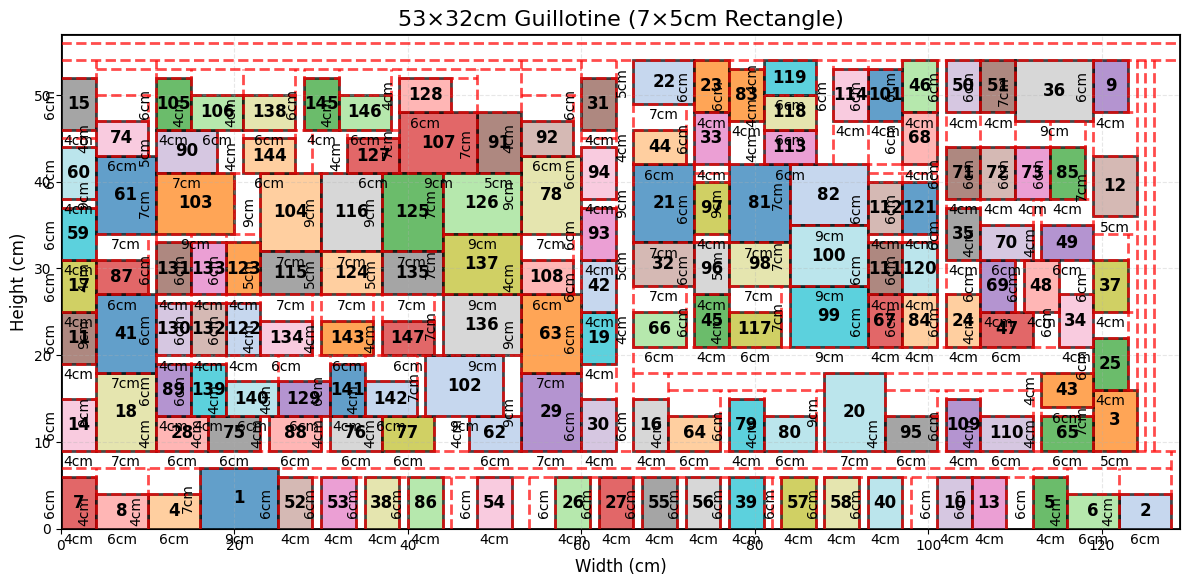

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
from typing import List, Dict, Tuple

def visualize_cutting_result(grid: Tuple[int, int], blocks: List[Dict], 
                            cuts: List[List] = None, title: str = "板材切割结果"):
    """
    可视化板材切割结果
    
    参数:
    grid: 板材尺寸 (宽度, 高度)
    blocks: 切割出的矩形列表，每个元素包含:
        - 'shape': (宽度, 高度)
        - 'position': (左下角x坐标, 左下角y坐标)
        - 'corners': 矩形的四个角点坐标
    cuts: 切割线列表 (可选)
    title: 图表标题
    """
    # 创建图形和坐标轴
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 设置坐标轴范围
    ax.set_xlim(0, grid[0])
    ax.set_ylim(0, grid[1])
    
    # 绘制板材边界
    ax.add_patch(patches.Rectangle(
        (0, 0), grid[0], grid[1], 
        edgecolor='black', facecolor='none', linewidth=2
    ))
    
    # 创建颜色映射
    colors = plt.cm.tab20.colors
    # random.shuffle(colors)
    
    # 绘制切割出的矩形
    for i, block in enumerate(blocks):
        shape = block['shape']
        pos_x, pos_y = block['position']
        width, height = shape
        
        # 随机选择颜色
        color = colors[i % len(colors)]
        
        # 绘制矩形
        rect = patches.Rectangle(
            (pos_x, pos_y), width, height,
            edgecolor='black', facecolor=color, 
            linewidth=2, alpha=0.7
        )
        ax.add_patch(rect)
        
        # 添加矩形编号
        center_x = pos_x + width / 2
        center_y = pos_y + height / 2
        ax.text(center_x, center_y, f"{i+1}", 
                fontsize=12, fontweight='bold', 
                ha='center', va='center')
        
        # 添加尺寸标注
        ax.text(pos_x + width/2, pos_y - 0.5, f"{width}cm", 
                fontsize=10, ha='center', va='top')
        ax.text(pos_x - 0.5, pos_y + height/2, f"{height}cm", 
                fontsize=10, ha='right', va='center', rotation=90)
    
    # 绘制切割线（如果有）
    if cuts:
        for cut in cuts:
            # 切割线是两点之间的线段
            start, end = cut
            ax.plot([start[0], end[0]], [start[1], end[1]], 
                    'r--', linewidth=2, alpha=0.7)
    
    # 添加标题和标签
    plt.title(title, fontsize=16)
    plt.xlabel("Width (cm)", fontsize=12)
    plt.ylabel("Height (cm)", fontsize=12)
    
    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 设置坐标轴比例相等
    ax.set_aspect('equal')
    
    # 显示结果
    plt.tight_layout()
    plt.show()

# 示例使用
if __name__ == "__main__":
    # 板材尺寸
    grid = (129, 57)

    
    # 可视化结果
    visualize_cutting_result(grid, blocks, cuts, "53×32cm Guillotine (7×5cm Rectangle)")